In [ ]:
####import all necessary packages####
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from scipy.stats import norm
from scipy.spatial.distance import cdist

from sklearn.gaussian_process.kernels import Matern

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import seaborn as sns

def acquisition_EI(X, Ysamples, model, xi=0.01):

    best = np.max(Ysamples)
    mu, std = model.predict(X,return_std=True)
    std = std.reshape(-1,1)
    imp = mu.reshape(-1,1) - best-xi
    Z = imp / std
    ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
    ei[std == 0.0] = 0.0

    return ei
    
    

def loocv_GP(lengthscale):
    kernel = ConstantKernel(constant_value = 1.03**2, constant_value_bounds='fixed') \
            *Matern(length_scale=lengthscale, length_scale_bounds='fixed', nu=2.5) \
            + WhiteKernel(noise_level=0.13, noise_level_bounds='fixed')
    gpr = GaussianProcessRegressor(kernel=kernel)

    X_1 = X_scaled_train_loocv
    X_2 = X_scaled_test_loocv
    y_1 = y_scaled_train_loocv
    y_2 = y_scaled_test_loocv

    gpr.fit(X_1, y_1)
    print(gpr.kernel_)
    mean_test,std_test = gpr.predict(X_2,return_std=True)
    mean_train,std_train = gpr.predict(X_1,return_std=True)
    LML = gpr.log_marginal_likelihood(gpr.kernel_.theta)
    return LML, mean_test,std_test,mean_train,std_train

1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5

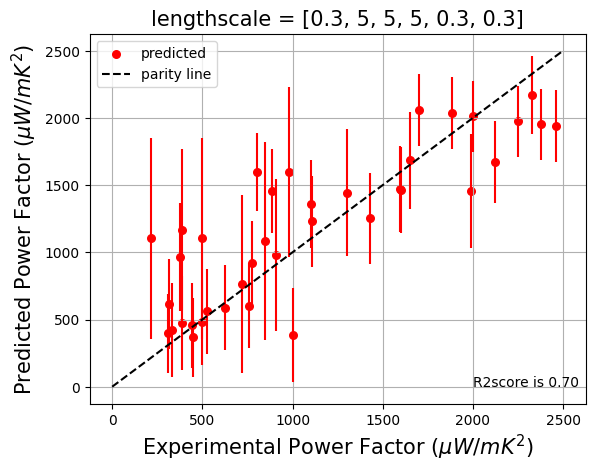

In [ ]:
#######Generate LOOCV parity plot for literature dataset #############
#######read literature data ###################
df = pd.read_excel('./Composition optimization-0924.xlsx')
df = df[['Ag', 'Se', 'S', 'Cu', 'Te', 't/um', 'Power factor']]
################### convert pandas dataframe to numpy array and normalize data
X = np.array(df[df.columns[0:-1]])
y = np.array(df[df.columns[-1]]).reshape(-1,1)

X_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_scaled = y_scaler.transform(y)

#######Leave-one-out cross validation############
kf = KFold(n_splits=len(X_scaled), shuffle=False)

ytest = []    #LOOCV ground truth PF 
ytest_std = []  #LOOCV predicted STD
ypred = []   #LOOCV predicted mean
lml_list = []  #log marginal likelihood
for train_index, test_index in kf.split(X_scaled):
    X_scaled_train_loocv,X_scaled_test_loocv = X_scaled[train_index],X_scaled[test_index]

    y_scaled_train_loocv,y_scaled_test_loocv = y_scaled[train_index],y_scaled[test_index]

    LML, mean_test, std_test, _, _ = loocv_GP([0.3, 5, 5, 5, 0.3, 0.3])   #use the predifined kernel to do LOOCV

    ytest_std.append(std_test)
    ypred.append(mean_test)
    ytest.append(y_scaled_test_loocv)
    lml_list.append(LML)

R2score = r2_score(np.array(ytest).reshape(-1), np.array(ypred).reshape(-1))
#######inverse transform for the scaled data
ytest = y_scaler.inverse_transform(np.array(ytest).squeeze(1))
ypred = y_scaler.inverse_transform(np.array(ypred).reshape(-1,1))
ytest_std = np.array(ytest_std) * np.sqrt(y_scaler.var_)


#######make plot ##############
plt.scatter(ytest, ypred, 30, c='r', marker='o', label='predicted')
plt.errorbar(ytest.reshape(-1), ypred.reshape(-1), ytest_std.reshape(-1),c='r', fmt = ' ')

plt.plot([0,2500],[0,2500],'k--', label='parity line')
plt.xlabel('Experimental Power Factor ($\mu W/mK^2$)',fontdict={'size':15})
plt.ylabel('Predicted Power Factor ($\mu W/mK^2$)', fontdict={'size':15})
plt.title(f'lengthscale = [0.3, 5, 5, 5, 0.3, 0.3]', fontdict={'size':15})
plt.grid(True)
plt.text(2000, 0, f'R2score is {R2score:.2f}')
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######import only literature data#######
df = pd.read_excel('./Composition optimization-0924.xlsx')
df = df[['Ag', 'Se', 'S', 'Cu', 'Te', 't/um', 'Power factor']]

######each experiment trial recorded here######
round1 = {'Ag':[1.9,1.9,1.9,1.9], 'Se':[1.3,1.3,1.3,1.3], 'S':[0.05,0.05,0.05,0.05], 'Cu':[0.15,0.15,0.15,0.15], 'Te':[0.01,0.01,0.01,0.01], 't/um':[190, 140, 107, 112], 'Power factor':[1460, 1896, 1710, 1957]}
round2 = {'Ag':[1.9,1.9,1.9,1.9], 'Se':[1.1,1.1,1.1,1.1], 'S':[0.02,0.02,0.02,0.02], 'Cu':[0.13,0.13,0.13,0.13], 'Te':[0,0,0,0], 't/um':[100,41,37,173], 'Power factor':[2351,2068,1621,1356]}
round3 = {'Ag':[1.95,1.95,1.95], 'Se':[1.05,1.05,1.05], 'S':[0.01,0.01,0.01], 'Cu':[0.01,0.01,0.01,], 'Te':[0,0,0], 't/um':[63,75,84], 'Power factor':[1607,1482,1296]}
round4 = {'Ag':[1.9,1.9], 'Se':[1.35,1.35], 'S':[0,0], 'Cu':[0.13,0.13,], 'Te':[0.001,0.001], 't/um':[143,73], 'Power factor':[1604,1819]}
round5 = {'Ag':[1.9,1.9], 'Se':[1.15,1.15], 'S':[0.005,0.005], 'Cu':[0.14,0.14,], 'Te':[0.00,0.00], 't/um':[111,109], 'Power factor':[1871,1769]}
expert_trial = {'Ag':[1.9,1.9], 'Se':[1.1,1.1], 'S':[0.005,0.005], 'Cu':[0.1,0.1,], 'Te':[0.00,0.00], 't/um':[148,121], 'Power factor':[1263,1524]}
round6 = {'Ag':[1.9,1.9,1.9,1.9,1.9], 'Se':[1.1,1.1,1.1,1.1,1.1], 'S':[0.002,0.002,0.002,0.002,0.002], 'Cu':[0.14,0.14,0.14,0.14,0.14], 'Te':[0.00,0.00,0,0,0], 't/um':[82.4,68.9,121,74.2,82.1], 'Power factor':[2278.9,2243.9,1438.47,2510.8,2295]}
round7 = {'Ag':[1.9,1.9,1.9], 'Se':[1.2,1.2,1.2,], 'S':[0.001,0.001,0.001,], 'Cu':[0.24,0.24,0.24,], 'Te':[0.00,0.00,0], 't/um':[60,85,88,], 'Power factor':[1165,929,860]}
round8 = {'Ag':[1.9,], 'Se':[1.1], 'S':[0.005], 'Cu':[0.08], 'Te':[0], 't/um':[80], 'Power factor':[1407]}
round9 = {'Ag':[1.85], 'Se':[1.1], 'S':[0.005], 'Cu':[0.19], 'Te':[0], 't/um':[80], 'Power factor':[1162]}
######convert to pandas data frame##########
round1 = pd.DataFrame(round1)
round2 = pd.DataFrame(round2)
round3 = pd.DataFrame(round3)
round4 = pd.DataFrame(round4)
round5 = pd.DataFrame(round5)
round6 = pd.DataFrame(round6)
round7 = pd.DataFrame(round7)
round8 = pd.DataFrame(round8)
round9 = pd.DataFrame(round9)
expert_trial = pd.DataFrame(expert_trial)
######add experimental data to literature dataset
df = df.append([round1, round2, round3, round4 , round5, round6, round7, round8, round9, expert_trial])

<ipython-input-13-b679e0775e6d>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([round1, round2, round3, round4 , round5, round6, round7, round8, round9, expert_trial])


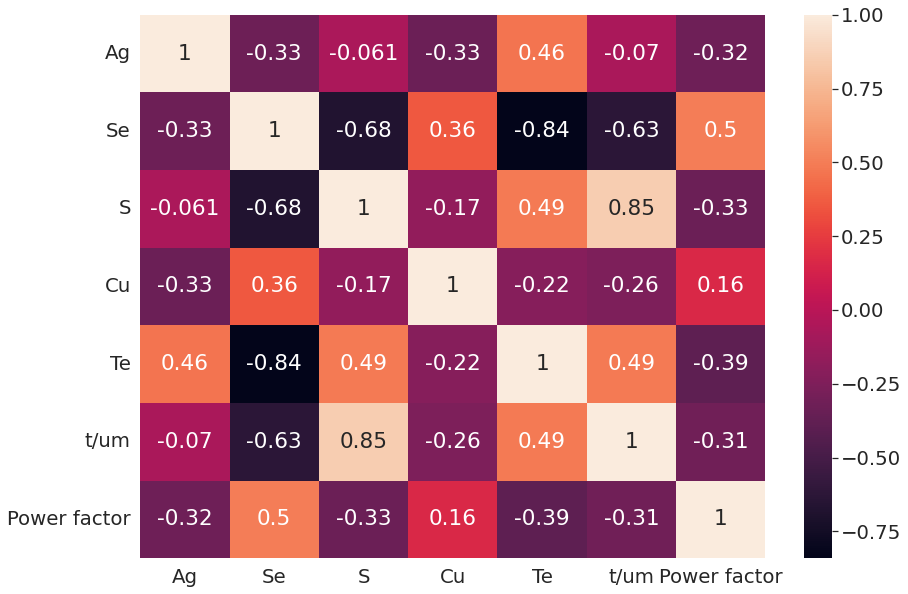

In [ ]:
#######plot the correlation matrix##############
corr = df.corr()
sns.set(font_scale=1.8)
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot= True)

In [ ]:
########Normalizing data ######
X = np.array(df[df.columns[0:-1]])
y = np.array(df[df.columns[-1]]).reshape(-1,1)

X_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_scaled = y_scaler.transform(y)

In [ ]:
#defining GP model and GP model training

kernel = ConstantKernel(constant_value = 1, constant_value_bounds=(0.05,5)) \
         *Matern(length_scale= np.random.uniform(0.3, 5, 6), length_scale_bounds=[0.3,5], nu=2.5) \
         + WhiteKernel(noise_level=0.16**2, noise_level_bounds=(0.01,0.8))   ######here we use is a Matern kernal + white noise kernel
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, n_restarts_optimizer=100)   ######use multistart
gpr.fit(X_scaled, y_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWar

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[2.16, 3.38, 2.2, 1.61, 0.408, 4.11], nu=2.5) + WhiteKernel(noise_level=0.0256),
                         n_restarts_optimizer=100, random_state=0)

1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5, 5, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.13)
1.03**2 * Matern(length_scale=[0.3, 5, 5

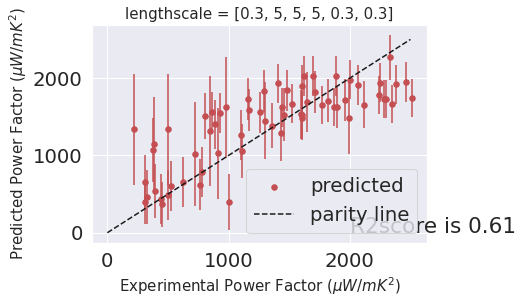

In [ ]:
#######LOOCV for all data############
kf = KFold(n_splits=len(X_scaled), shuffle=False)

ytest = []    #LOOCV ground truth PF 
ytest_std = []  #LOOCV predicted STD
ypred = []   #LOOCV predicted mean
lml_list = []  #log marginal likelihood
for train_index, test_index in kf.split(X_scaled):
    X_scaled_train_loocv,X_scaled_test_loocv = X_scaled[train_index],X_scaled[test_index]

    y_scaled_train_loocv,y_scaled_test_loocv = y_scaled[train_index],y_scaled[test_index]

    LML, mean_test, std_test, _, _ = loocv_GP([0.3, 5, 5, 5, 0.3, 0.3])  ####get the LOOCV result with predifined kernel

    ytest_std.append(std_test)
    ypred.append(mean_test)
    ytest.append(y_scaled_test_loocv)
    lml_list.append(LML)

R2score = r2_score(np.array(ytest).reshape(-1), np.array(ypred).reshape(-1))

ytest = y_scaler.inverse_transform(np.array(ytest).squeeze(1))
ypred = y_scaler.inverse_transform(np.array(ypred).reshape(-1,1))
ytest_std = np.array(ytest_std) * np.sqrt(y_scaler.var_)


#######plot the parity plot
plt.scatter(ytest, ypred, 30, c='r', marker='o', label='predicted')
plt.errorbar(ytest.reshape(-1), ypred.reshape(-1), ytest_std.reshape(-1),c='r', fmt = ' ')

plt.plot([0,2500],[0,2500],'k--', label='parity line')
plt.xlabel('Experimental Power Factor ($\mu W/mK^2$)',fontdict={'size':15})
plt.ylabel('Predicted Power Factor ($\mu W/mK^2$)', fontdict={'size':15})
plt.title(f'lengthscale = [0.3, 5, 5, 5, 0.3, 0.3]', fontdict={'size':15})
plt.grid(True)
plt.text(2000, 0, f'R2score is {R2score:.2f}')
plt.legend()

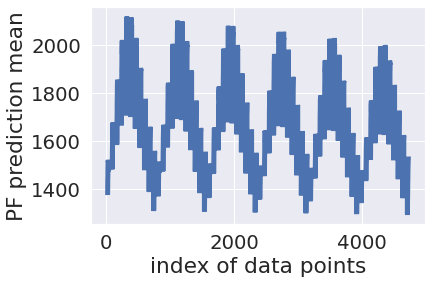

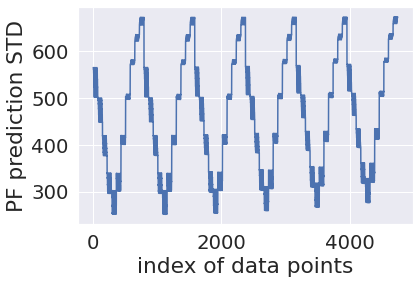

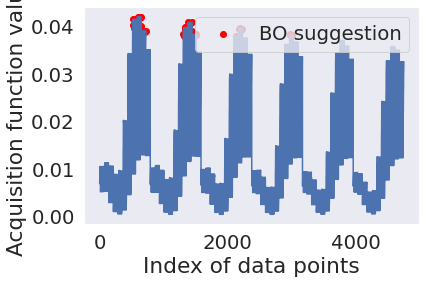

In [ ]:
#######define the resolution of each parameter ##############
Ag_range = np.arange(1.7,2.2,0.05) 
Se_range = np.arange(1.1,1.4,0.05) 
S_range = np.arange(0.0,0.02,0.005)
Cu_range = np.arange(0.1,0.16,0.01)
Te_range = np.arange(0,0.003,0.001)
thickness_range = np.arange(60,61,10)
Ag_grid, Se_grid, S_grid, Cu_grid, Te_grid, thickness_grid = np.meshgrid(Ag_range, Se_range, S_range, Cu_range, Te_range, thickness_range, )
X_all = np.concatenate((Ag_grid.reshape(-1,1), Se_grid.reshape(-1,1), S_grid.reshape(-1,1), Cu_grid.reshape(-1,1), Te_grid.reshape(-1,1), thickness_grid.reshape(-1,1),),axis=1)


###########GP prediction ###############
X_all = X_scaler.transform(X_all)  #standardize input
mean_all,mean_std = gpr.predict(X_all,return_std=True)  #get GP prediction
######plot GP prediction vs. index of each condition
plt.figure()
plt.plot(y_scaler.inverse_transform(mean_all.reshape(-1,1)))
plt.xlabel('index of data points')
plt.ylabel('PF prediction mean')
plt.figure()
plt.plot(mean_std * np.sqrt(y_scaler.var_))
plt.xlabel('index of data points')
plt.ylabel('PF prediction STD')
acq_value = acquisition_EI(X_all, y_scaled, gpr)
plt.figure()

###############BO recommendation ################
largest_index = np.flip(np.argsort(acq_value,axis=0)).reshape(-1)  #sort the acquisition function result
BOdatapoints = largest_index[::3][:50]   #pick up 1 every 3 to increase the diversity of recommended conditions 
plt.plot(acq_value)
plt.xlabel('Index of data points')
plt.ylabel('Acquisition function value')
plt.grid()

plt.scatter(BOdatapoints[:50], acq_value[BOdatapoints[:50]], c = 'red', label = 'BO suggestion')
plt.legend()
######convert BO recommendation to pandas DF and output as excel file
bosuggestionsdf = pd.DataFrame(X_scaler.inverse_transform(X_all[BOdatapoints]))
namelist= ['Ag', 'Se', 'S', 'Cu', 'Te', 'thickness']
bosuggestionsdf.columns = namelist
bosuggestionsdf['predictedPF']=y_scaler.inverse_transform(gpr.predict(X_all[BOdatapoints]).reshape(-1,1))
bosuggestionsdf.to_excel('./newdata.xlsx')
